In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import datetime
from dual import dual
from uniform import uniform
import ray
import logging
%matplotlib inline

In [2]:
EPSILON = 0.000001
def myround(num):
    num = num if abs(num) > EPSILON else 0
    return num


def get_return_probability(m, pon, kernel):
    assert kernel in ['sqrt', 'linear']

    if kernel == "sqrt":
        return min(m * pon ** (1 / 2), 1)
    elif kernel == "linear":
        return min(m * pon, 1)


In [3]:
@ray.remote
def get_uniform_result(c, con, cr, rho, model_para, kernel, step, density):
    uniform_ins = uniform(c=c, con=con, rho=rho, model_para=model_para, cr=cr, kernel=kernel, step=step, density=density)
    return uniform_ins.p, uniform_ins.profit


@ray.remote
def get_dual_result(c, con, cr, rho, model_para, kernel, step, density):
    dual_ins = dual(c=c, con=con, rho=rho, model_para=model_para, cr=cr, step=step, kernel=kernel, density=density)
    return dual_ins.pon, dual_ins.poff, dual_ins.profit


def main(vals, filenames, plot=False, save=False, **kwargs):
    for val, filename in zip(vals, filenames):
        model_para = {"a":0.0,"b":val}
        p_list = []
        piu_list = []

        pon_list = []
        poff_list = []
        pid_list = []

        rho =  kwargs["rho"]
        cr = kwargs["cr"]
        con = kwargs["con"]
        step = kwargs["step"]
        density = kwargs["density"]
        sel_c = kwargs["sel_c"]
        kernel =kwargs["kernel"]

        results_uniform_id = []
        results_dual_id = []

        for c in sel_c:
            results_uniform_id.append(
                get_uniform_result.remote(c=c, con=con, cr=cr, rho=rho,model_para=model_para, kernel=kernel,step=step, density=density))
            results_dual_id.append(
                get_dual_result.remote(c=c, con=con, cr=cr, rho=rho, model_para=model_para, kernel=kernel, step=step, density=density))

        results_uniform = ray.get(results_uniform_id)
        results_dual = ray.get(results_dual_id)

        for result_uniform, result_dual in zip(results_uniform, results_dual):
            p_list.append(result_uniform[0])
            piu_list.append(result_uniform[1])

            pon_list.append(result_dual[0])
            poff_list.append(result_dual[1])
            pid_list.append(result_dual[2])

        if plot:
            fig = plt.figure(figsize=(5, 8))
            ax1 = fig.add_subplot(2, 1, 1)
            ax1.plot(sel_c, piu_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax1.plot(sel_c, pid_list, c='blue', ls='--', ms=6, marker='o', label="Dual")

            ax2 = fig.add_subplot(2, 1, 2)
            ax2.plot(sel_c, p_list, c='red', ls='--', ms=6, marker='*', label="Uniform")
            ax2.plot(sel_c, pon_list, c='blue', ls='--', ms=6, marker='o', label="Online of Dual")
            ax2.plot(sel_c, poff_list, c='green', ls='--', ms=6, marker='D',
                     label="Offline of Dual")

            ax1.legend(prop=dict(size=9), frameon=False)
            ax1.set_ylabel("Profits", fontsize=16)
            ax1.set_xlabel("c", fontsize=16)

            ax2.legend(prop=dict(size=9), frameon=False)
            ax2.set_ylabel("Prices", fontsize=16)
            ax2.set_xlabel("c", fontsize=16)

            plt.tight_layout()
            plt.show()
        if save:
            cols = ["c", "p_u", "pi_u", "pon", "poff", "pi_d"]
            data = np.array([sel_c, p_list, piu_list, pon_list, poff_list, pid_list]).T

            data_frame = pd.DataFrame(data=data, columns=cols)
            data_frame.to_excel(filename, index=False)

        logger.info("a work is finished...")

In [13]:
def plot(data, vals, fz=(20,8)):
    epsilon = 0.0000001
    fig,axes = plt.subplots(2, len(data), sharex='col', sharey='row',figsize=fz)
    fig.subplots_adjust(hspace=0.6, wspace=0.4)
    for j,current_data  in enumerate(data):
        sel_c = current_data["c"]
        min_c_ind = min(sel_c)
        max_c_ind = max(sel_c)
        step = sel_c[1]-sel_c[0]

        sel_prices_u = current_data["p_u"]
        sel_prices_d_on =  current_data["pon"]
        sel_prices_d_off =  current_data["poff"]
        sel_profits_u = current_data["pi_u"]
        sel_profits_d = current_data["pi_d"]
        
#         HP_zone= (sel_profits_u > sel_profits_d)
#         HP_c = sel_c[current_data[HP_zone].index]
        
        HPLP_zone=(sel_prices_u-sel_prices_d_on <epsilon) & (sel_profits_u -sel_profits_d>epsilon)
        HPLP_c = sel_c[current_data[HPLP_zone].index]
        if not HPLP_c.empty:
            HPLP_c_min = min(HPLP_c)
            HPLP_c_max = max(HPLP_c)

        axes[0,j].scatter(sel_c, sel_prices_u,  marker='*', s=50, facecolors='none', edgecolors='r',label="Uniform price")
        axes[0,j].scatter(sel_c, sel_prices_d_on, marker=".",s=50,facecolors='none', edgecolors='b',label="Dual online price")
        axes[0,j].scatter(sel_c, sel_prices_d_off, marker= "+", s=50, edgecolors='g',label="Dual offline price")
        
        if not HPLP_c.empty:
            axes[0,j].axvspan(HPLP_c_min, HPLP_c_max, alpha=0.5, facecolor='none',edgecolor='black',linestyle='--')
        
        if j==len(data)-1:
            axes[0,j].legend(prop=dict(size=18), frameon=True)

        #axes[0,j].set_xlabel("c", fontsize =16)

        axes[0,j].set_title(r"$\delta_H$={} ".format(vals[j]), fontsize=22)
#         axes[0,j].set_xlim((0.1,0.17))
#         axes[0,j].set_ylim((0.28,0.46))
        
        for label in (axes[0,j].get_xticklabels() + axes[0,j].get_yticklabels()):
            label.set_fontsize(16)

#         ax.scatter(c_test, piu_test, marker='*', s=12, facecolors='none', edgecolors='r',label="Uniform")
#         ax.scatter(c_test, pid_test,marker=".",s=6,facecolors='none', edgecolors='b',label="Dual")
        axes[1,j].scatter(sel_c, sel_profits_u, marker='*', s=50, facecolors='none', edgecolors='r',label="Uniform pricing")
        axes[1,j].scatter(sel_c, sel_profits_d, marker=".",s=50,facecolors='none', edgecolors='b',label="Dual pricing")
        if not HPLP_c.empty:
            axes[1,j].axvspan(HPLP_c_min, HPLP_c_max, alpha=0.5, facecolor='none',edgecolor='black',linestyle='--')
        
        if j==len(data) -1:
            axes[1,j].legend(prop=dict(size=18), frameon=True)
#         axes[1,j].set_ylim((0.03,0.042))
#         axes[1,j].set_xlim((0.1,0.17))
        
        for label in (axes[1,j].get_xticklabels() + axes[1,j].get_yticklabels()):
            label.set_fontsize(16)
    axes[0,0].set_ylabel("Prices", fontsize =22)
    axes[1,0].set_ylabel("Profits", fontsize =22)
    fig.text(0.5, 0, 'c', ha='center',fontsize =22)
    fig.tight_layout()
    return fig

##  return funciton is set as  Linear

In [189]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


# logging.basicConfig()
# logger = logging.getLogger("plot")
# logger.setLevel(logging.INFO)
# start_time = datetime.datetime.now()

# # ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
# vals = [0.3, 0.4,0.5,0.6,0.7] 
# filenames = []
# for ind, _ in enumerate(vals):
#     filenames.append("file"+str(ind)+".xlsx")

    
# rho=0
# cr = 0.32
# con = 0.05
# step = 0.001
# density = 0.005
# sel_c = np.arange(0.1, 0.25, 0.005)
# kernel="linear"
# input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

# main(vals=vals, filenames=filenames, plot=False, save=True, **input_kwargs)

# end_time = datetime.datetime.now()
# logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


# data = []
# for filename in filenames:
#     data.append(pd.read_excel(filename))
# #     print(pd.read_excel(filename).head(5))
# myfig = plot(data ,vals=vals, fz=(20,12))

In [6]:
vals = [0.2,0.5,0.8] 
# vals = [0.3,0.5,0.7] 
filenames = []
for ind, _ in enumerate(vals):
    filenames.append("file"+str(ind)+".xlsx")


INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 32 seconds


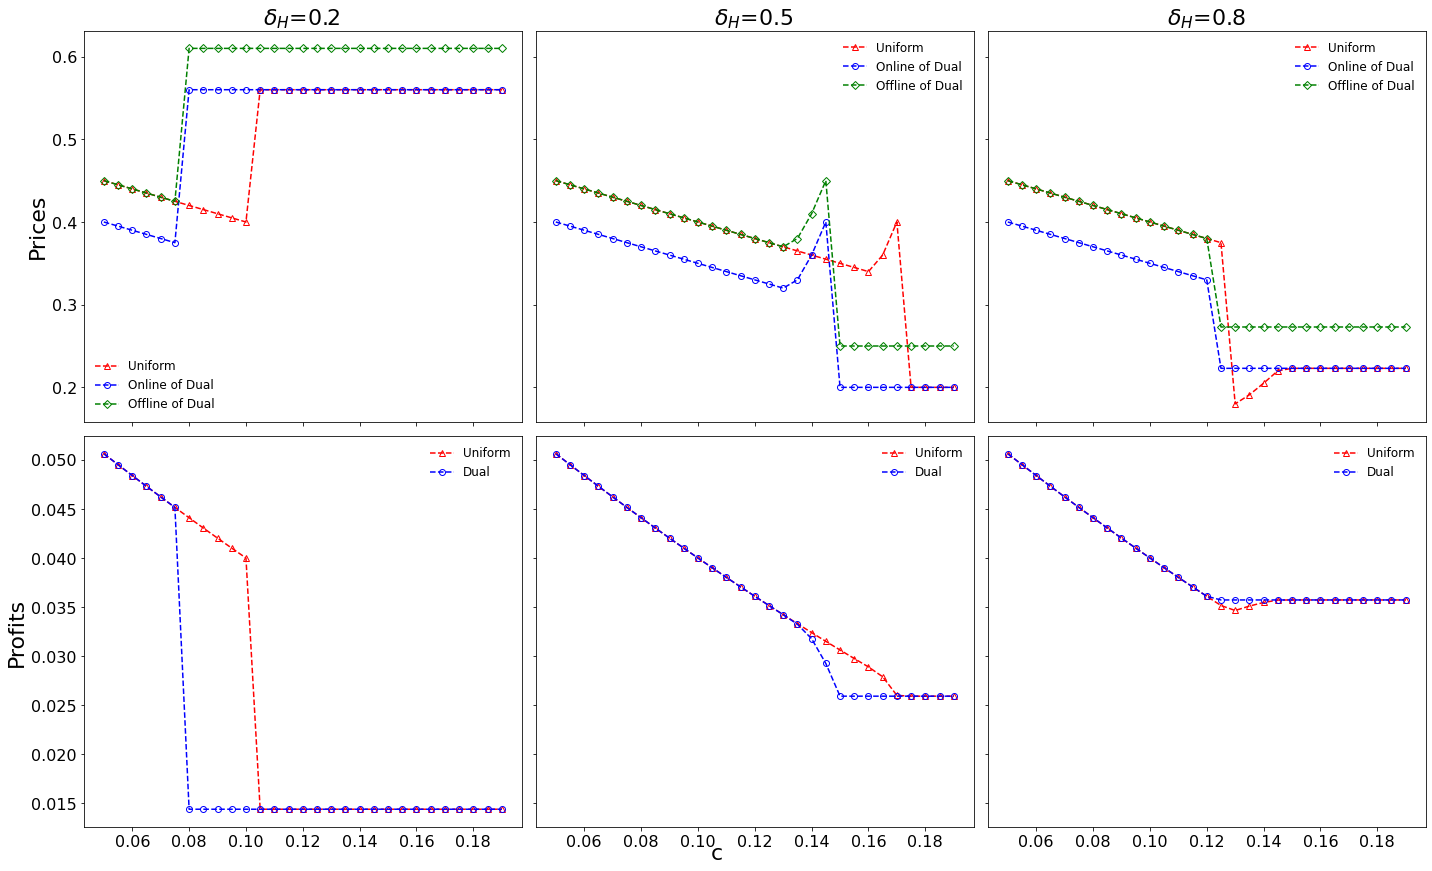

In [5]:
# ms = [2]
# filenames=["None"]
# main(ms, filenames, save=False, plot=True)


logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
# vals = [0.1,0.2,0.3,0.5,0.7,0.8, 0.9] 
vals = [0.2,0.5,0.8] 
# vals = [0.3,0.5,0.7] 
filenames = []
for ind, _ in enumerate(vals):
    filenames.append("file"+str(ind)+".xlsx")

    
rho=0
cr = 0.32
con = 0.05
step = 0.001
density = 0.005
sel_c = np.arange(0.05, 0.19, 0.005)
kernel="linear"
input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(vals=vals, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))

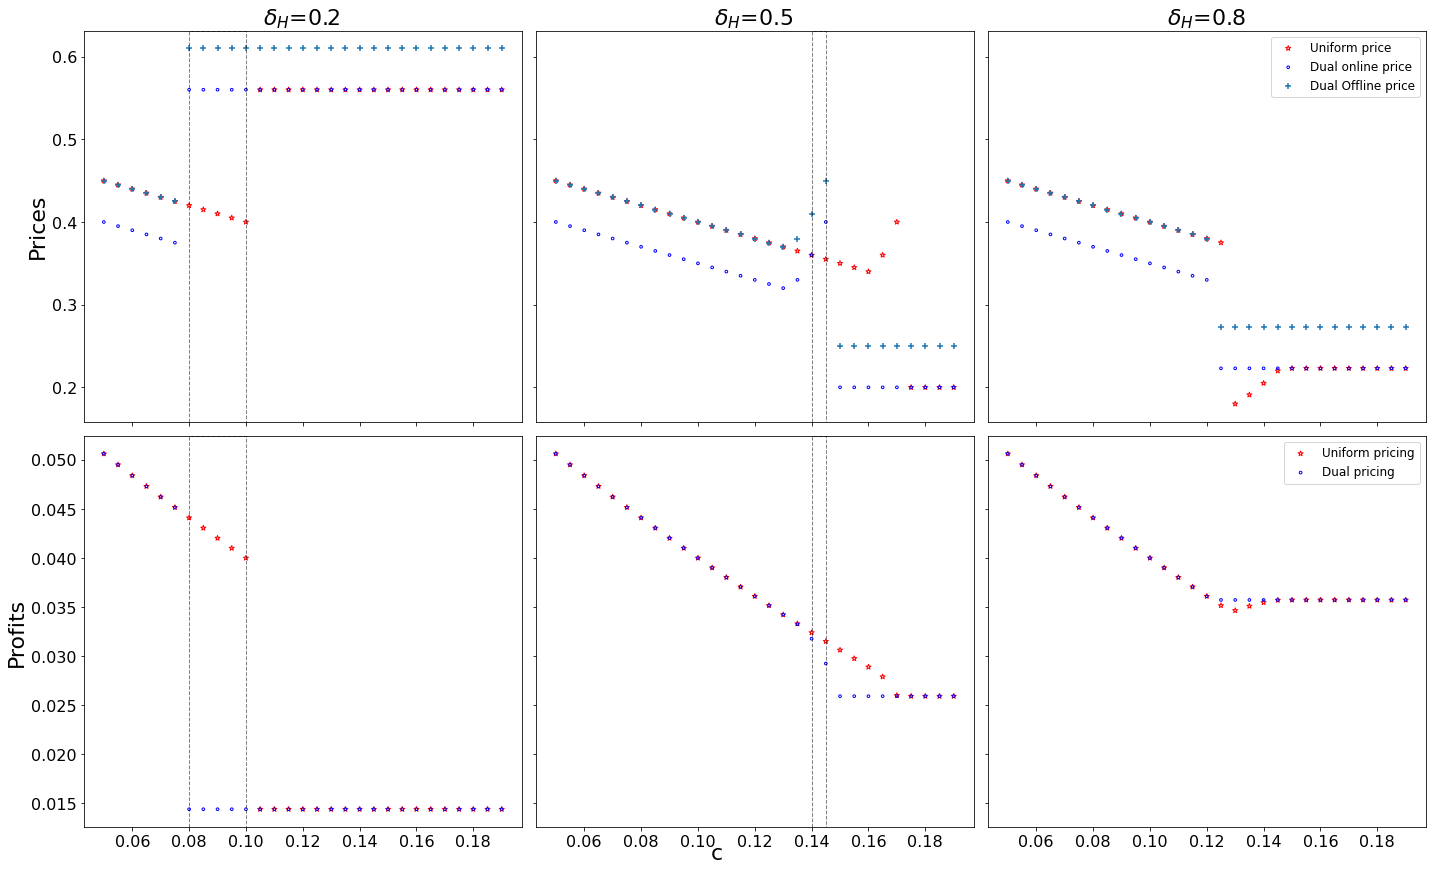

In [18]:
data = []
for filename in filenames:
    data.append(pd.read_excel(r"C:\Users\admin\Desktop\managing multirooming\round 3\REcodes\venv\price_related_return/"+filename))
#     print(pd.read_excel(filename).head(5))

#  for the complete figures, use ipython environment.


myfig = plot(data ,vals=vals, fz=(20,12))

In [7]:
myfig.savefig("C:/Users/admin/Desktop/managing multi-rooming/round 3/PriceRelatedReturn.pdf")

INFO:plot:a work is finished...
INFO:plot:a work is finished...
INFO:plot:Total time: 4 seconds


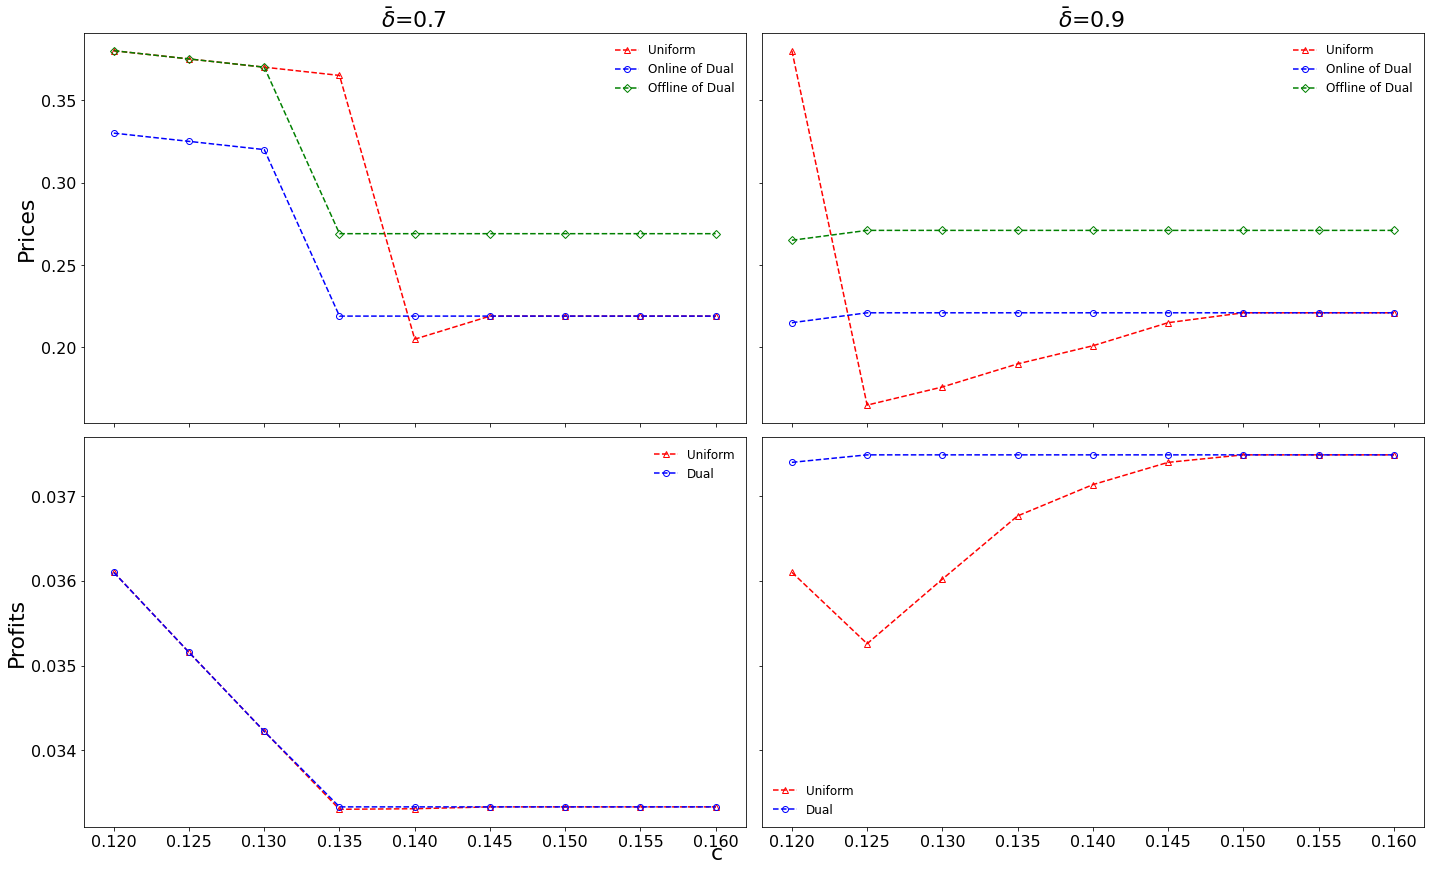

In [7]:

logging.basicConfig()
logger = logging.getLogger("plot")
logger.setLevel(logging.INFO)
start_time = datetime.datetime.now()

# ms = ["constant", 1.348, 1.350, 1.352, 1.354]  # sensitivity of return probability with cr=0.35, con=0.05
vals = [0.7,0.9] 
filenames = []
for ind, _ in enumerate(vals):
    filenames.append("file"+str(ind)+".xlsx")

    
rho=0
cr = 0.32
con = 0.05
step = 0.001
density = 0.005
sel_c = np.arange(0.12, 0.16, 0.005)
kernel="linear"
input_kwargs = {'cr': cr, 'con':con, 'rho': rho, 'step':step, 'density':density, 'sel_c':sel_c, 'kernel':kernel}

main(vals=vals, filenames=filenames, plot=False, save=True, **input_kwargs)

end_time = datetime.datetime.now()
logger.info("Total time: {} seconds".format((end_time - start_time).seconds))


data = []
for filename in filenames:
    data.append(pd.read_excel(filename))
#     print(pd.read_excel(filename).head(5))

myfig = plot(data ,vals=vals, fz=(20,12))